In [1]:
import numpy as np
import pandas_datareader.data as web
import pandas as pd
import pandas_ta as ta
import pandas_market_calendars as mcal
from dotenv import load_dotenv
from datetime import datetime, timedelta
import matplotlib
import matplotlib.pyplot as plt
import yfinance as yf
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from torchinfo import summary
import torchvision.transforms as transforms
import time
from sklearn.metrics import mean_squared_error

In [2]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {DEVICE} for inference')

Using cuda for inference


In [3]:
shapes = np.load('shapes.npy',allow_pickle=True)
X_shape = shapes.item()['X']
y_shape = shapes.item()['y']

In [4]:
X = np.memmap('X_sequence.dat', dtype='float64', mode='r+', shape=X_shape)
Y = np.memmap('Y_sequence.dat', dtype='float64', mode='r+', shape=y_shape)

In [5]:
class ValidationLossEarlyStopping:
    def __init__(self, patience=1, min_delta=0.0):
        self.patience = patience  # number of times to allow for no improvement before stopping the execution
        self.min_delta = min_delta  # the minimum change to be counted as improvement
        self.counter = 0  # count the number of times the validation accuracy not improving
        self.min_validation_loss = np.inf

    # return True when validation loss is not decreased by the `min_delta` for `patience` times 
    def early_stop_check(self, validation_loss):
        if ((validation_loss+self.min_delta) < self.min_validation_loss):
            self.min_validation_loss = validation_loss
            self.counter = 0  # reset the counter if validation loss decreased at least by min_delta
        elif ((validation_loss+self.min_delta) > self.min_validation_loss):
            self.counter += 1 # increase the counter if validation loss is not decreased by the min_delta
            if self.counter >= self.patience:
                return True
        return False

In [6]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))

    def forward(self, encoder_outputs, hidden):
        seq_len = encoder_outputs.size(1)
        hidden = hidden.repeat(seq_len, 1, 1).transpose(0, 1)
        energy = torch.tanh(self.attn(torch.cat((encoder_outputs, hidden), dim=2)))
        energy = energy.transpose(1, 2)
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)
        attention_scores = torch.bmm(v, energy).squeeze(1)
        attention_weights = torch.softmax(attention_scores, dim=1)
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        return context

In [7]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2,rnn_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.rnn_layers = rnn_layers
        
        # LSTM layer
        self.lstm_layers = nn.ModuleList()

        for i in range(self.rnn_layers):
            lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,batch_first=True, dropout=dropout)
            input_size = hidden_size
            hidden_size = int(hidden_size * 2)
            self.lstm_layers.append(lstm)
        

        self.hidden_layer = nn.Linear(input_size, self.hidden_size)

        # Dropout layer to prevent overfitting
        self.dropout_layer = nn.Dropout(dropout)
        
        # Fully connected layer for output
        self.fc = nn.Linear(self.hidden_size, output_size)

        #Attention layer
        self.attention = Attention(self.hidden_size)
        
    def forward(self, x):
        # Initialize LSTM hidden state and cell state
        hidden_size = self.hidden_size
        
        # Forward pass through LSTM layers
        for i, lstm in enumerate(self.lstm_layers):
            h0 = torch.zeros(self.num_layers, x.size(0), hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers, x.size(0), hidden_size).to(x.device)

            x, (h_t,c_t) = lstm(x, (h0, c0))

            hidden_size = int(hidden_size*2)
            

        out = self.hidden_layer(x)

        context = self.attention(out, out[:, -1, :])
        
        # Dropout layer
        out = self.dropout_layer(context)
        
        # Fully connected layer
        out = self.fc(out)
        
        return out


In [8]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2, rnn_layers=1):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.rnn_layers = rnn_layers
        
        # GRU layer
        self.gru_layers = nn.ModuleList()
        for i in range(self.rnn_layers):
            gru = nn.GRU(input_size, hidden_size, num_layers=num_layers,batch_first=True, dropout=dropout)
            input_size = hidden_size
            hidden_size = int(hidden_size * 2)
            self.gru_layers.append(gru)

        #self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        self.hidden_layer = nn.Linear(input_size, self.hidden_size)

        # Dropout layer to prevent overfitting
        self.dropout_layer = nn.Dropout(dropout)

        # Fully connected layer for output
        self.fc = nn.Linear(self.hidden_size, output_size)

        #Attention layer
        self.attention = Attention(self.hidden_size)

    def forward(self, x):
        # Initialize GRU hidden state
        hidden_size = self.hidden_size
 
        # Forward pass through GRU layers
        for gru in self.gru_layers:
            h0 = torch.zeros(self.num_layers, x.size(0), hidden_size).to(x.device)

            x, h_t = gru(x, h0)

            hidden_size = int(hidden_size*2)
            

        out = self.hidden_layer(x)

        context = self.attention(out, out[:, -1, :])

        # Dropout layer
        out = self.dropout_layer(context)

        # Fully connected layer
        out = self.fc(out)

        return out

In [9]:
class CNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2, kernel_size=3):
        super(CNNModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.output_size = output_size

        self.cnn_layers = nn.ModuleList()

        input_size = self.input_size[1]
        k_size = self.input_size[2]

        for i in range(self.num_layers-1):
            cnn = nn.Sequential(
                nn.Conv1d(input_size, hidden_size, kernel_size=kernel_size),
                nn.ReLU()
            )

            input_size = hidden_size
            hidden_size = int(hidden_size * 2)
            k_size = int((k_size-kernel_size+1))

            self.cnn_layers.append(cnn)

        cnn = nn.Sequential(
            nn.Conv1d(input_size, self.input_size[1], kernel_size=kernel_size),
            nn.ReLU()
        )
        k_size = int((k_size-kernel_size+1))
        
        self.cnn_layers.append(cnn)

        # Flatten the output
        self.flatten = nn.Flatten()

        self.hidden_layer = nn.Linear(k_size, self.hidden_size)

        # Dropout layer to prevent overfitting
        self.dropout_layer = nn.Dropout(dropout)

        self.attention = Attention(self.hidden_size)

        # Fully connected layer for output
        self.fc = nn.Linear(self.hidden_size, self.output_size)

        self.flatten = nn.Flatten()

    def forward(self, x):
        
        for cnn in self.cnn_layers:
            x = cnn(x)

        x = self.hidden_layer(x)

        # Flatten the output
        context = self.attention(x, x[:, -1, :])

        # Dropout layer
        out = self.dropout_layer(context)

        # Fully connected layer
        out = self.fc(out)

        return out

In [10]:
class NNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(NNModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.output_size = output_size

        self.fc_layers = nn.ModuleList()

        # Fully connected layer for output
        for i in range(int(self.num_layers/2)):
            fc = nn.Sequential(
                nn.Linear(input_size, hidden_size),
                nn.ReLU()
            ) 
            input_size = hidden_size
            hidden_size = int(hidden_size*2)
            self.fc_layers.append(fc)
        
        for i in range(num_layers-int(self.num_layers/2)):     
            hidden_size = int(input_size/2)
            fc = nn.Sequential(
                nn.Linear(input_size, hidden_size),
                nn.ReLU()
            ) 
            input_size = hidden_size
            self.fc_layers.append(fc)

        self.hidden_layer = nn.Linear(hidden_size, self.hidden_size)

        self.dropout_layer = nn.Dropout(dropout)

        self.attention = Attention(self.hidden_size)

        self.flatten = nn.Flatten()

        # Fully connected layer for output
        self.fc = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        # Fully connected layer
        for fc in self.fc_layers:
            x = fc(x)
        
        # Hidden layer
        x = self.hidden_layer(x)

        context = self.attention(x, x[:, -1, :])

        # Dropout layer
        out = self.dropout_layer(context)

        # Fully connected layer
        x = self.fc(out)

        return x

        

In [11]:
class Ensemble_Model (nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2, kernel_size=3,rnn_layers=1, rnn_num_layers=1):
        super(Ensemble_Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.output_size = output_size
        self.kernel_size = kernel_size

        self.lstm_model = LSTMModel(input_size[2], hidden_size, rnn_num_layers, output_size, dropout, rnn_layers)
        self.gru_model = GRUModel(input_size[2], hidden_size, rnn_num_layers, output_size, dropout, rnn_layers)
        self.cnn_model = CNNModel(input_size, hidden_size, num_layers, output_size, dropout, kernel_size)
        self.nn_model = NNModel(input_size[2], hidden_size, num_layers, output_size, dropout)

        self.dropout_layer = nn.Dropout(dropout)

        self.fc = nn.Linear(4*output_size, output_size)
    
    def forward(self, x):
        lstm_out = self.lstm_model(x)
        gru_out = self.gru_model(x)
        cnn_out = self.cnn_model(x)
        nn_out = self.nn_model(x)

        out = torch.cat((lstm_out, gru_out, cnn_out, nn_out), 1)
        drop_out = self.dropout_layer(out)
        out = self.fc(drop_out)

        return out


In [12]:
class StockDataset(Dataset):
    def __init__(self, X, Y,transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = self.X[idx]
        Y = self.Y[idx]
        
        if self.transform:
            X = self.transform(X)
        
        X = torch.tensor(X, dtype=torch.float32)
        Y = torch.tensor(Y, dtype=torch.float32)

        return X, Y

In [13]:
def compute_accuracy (model, data_loader,device=DEVICE,eps=1):
    model = model.to(device)
    model = model.eval() # put the model to evaultion mode
    
    num_correct_prediction = 0
    num_total_labels = 0
    
    with torch.no_grad():
        
        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            probabilities = model(inputs)
            num_total_labels += (labels.size()[0] * labels.size()[1]) 
            num_correct_prediction += float((abs(probabilities - labels) <= eps).sum())
    return num_correct_prediction/num_total_labels * 100

In [14]:
from torch import Tensor


def train_model(model:nn.Module,train_loader:DataLoader,criterion:nn, optimizer:optim,scheduler: optim.lr_scheduler,val_loader:DataLoader,learning_rate=0.001, num_epochs=50, batch_size=32,device=DEVICE, gamma=0.1, step_size=5,verbose=True):
    
    start_time = time.time()
    found_epoch = 0

    if not os.path.exists('./ensmeble_chekpoint'):
        os.mkdir('./ensmeble_chekpoint')
    
    if os.path.exists('./ensmeble_chekpoint/model_checkpoint.pt'):
        print("Loading from checkpoint ...")

        checkpoint = torch.load('./ensmeble_chekpoint/model_checkpoint.pt')
        model.load_state_dict(checkpoint['model_state_dict'], strict=True)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        loss = checkpoint['loss']
        found_epoch = checkpoint['epoch']-1
        if found_epoch >= num_epochs:
            print("Already trained for {} epochs. Exiting ...".format(num_epochs))
            return model
        if found_epoch < 0:
            found_epoch = 0

        print(f"Resuming from epoch {found_epoch} with a loss of {loss} ...")
           
    else:
        torch.save({
            'epoch': found_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': float('inf'),
            }, './ensmeble_chekpoint/model_checkpoint.pt')

    best_accuracy = 0
    
    best_vloss = float('inf')

    batch_str_len = len(str(len(train_loader)))
    
    for epochs in range(found_epoch,num_epochs):
        model.train()
        print("EPOCH : {0}/{1}".format(epochs+1,num_epochs))
        print("-"*30)
        
        # train first
        model.train()
        for batch_index, (X, Y) in enumerate(train_loader):
            optimizer.zero_grad()

            output = model(X.to(DEVICE))
            
            loss = criterion(output , Y.to(DEVICE)) 

            loss.backward()
            optimizer.step()
            
            if (batch_index % 10 == 0) or (batch_index == len(train_loader)-1):
                print(f"BATCH : {batch_index:{batch_str_len}d}/{len(train_loader)-1:{batch_str_len}d} | LOSS : {loss:.3f} ")
        
        # evalute
        running_vloss = 0.0
        model.eval()
        with torch.set_grad_enabled(False):
            for batch_index, (X, Y) in enumerate(val_loader):
                voutput = model(X.to(DEVICE))
                running_vloss += criterion(voutput , Y.to(DEVICE))
            
            avg_loss = running_vloss / (batch_index+1)

            print("-"*30)
            print("\nAverage Loss On Validation Data : {:.2f}".format(avg_loss))
            print("-"*30)
        
        scheduler.step(metrics=avg_loss, epoch=epochs)
        
        if (avg_loss < best_vloss):
            best_vloss = avg_loss
            
            torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, './ensmeble_chekpoint/model_checkpoint.pt')
            
        print("Elapsed Time : {:.0f} min {:.0f} sec\n".format((time.time() - start_time)/60 , (time.time() - start_time)%60)) 
    
    print("\nTotal Time : {:.0f} min {:.0f} sec".format((time.time() - start_time)/60 , (time.time() - start_time)%60))
    
    torch.save(model, './ensmeble_chekpoint/model.pt')

    return model

In [15]:
# Define hyperparameters
input_size = X_shape[2]
hidden_size = 172
output_size = y_shape[1]
num_layers = 3
RNN_NUM_LAYERS = 2
RNN_LAYERS = 2

DROPOUT = 0.2
LEARNING_RATE = 0.001
BATCH_SIZE = 60
NUM_EPOCHS = 40
GAMMA = 0.1
PATIENCE = 2
MOMENTUM = 0.2
SHUFFLE = True

TEST_SPLIT = 0.15
VAL_SPLIT = 0.15
TEST_VALL_SPLIT = TEST_SPLIT + VAL_SPLIT
TRAIN_SPLIT = 1 - TEST_VALL_SPLIT

In [16]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = StockDataset(X, Y)
DATASET_SIZE = len(dataset)

train_data, test_data = random_split(dataset, [ int(TRAIN_SPLIT*DATASET_SIZE) , int(TEST_VALL_SPLIT*DATASET_SIZE)])
val_data, test_data = random_split(test_data, [ int(VAL_SPLIT*DATASET_SIZE) , int(TEST_SPLIT*DATASET_SIZE)])

train_loader = DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=SHUFFLE)
val_loader = DataLoader(dataset=val_data,batch_size=BATCH_SIZE,shuffle=SHUFFLE)
test_loader = DataLoader(dataset=test_data,batch_size=BATCH_SIZE,shuffle=SHUFFLE)

In [17]:
X_train, y_train = next(iter(train_loader))
print(X_train.shape, y_train.shape)

torch.Size([60, 1825, 308]) torch.Size([60, 182])


In [18]:
model = Ensemble_Model(input_size=X_shape, hidden_size=hidden_size, num_layers=num_layers, rnn_layers=RNN_LAYERS,output_size=output_size, dropout=DROPOUT, rnn_num_layers=RNN_NUM_LAYERS).to(DEVICE)
summary(model, input_size=(BATCH_SIZE, X_shape[1], X_shape[2]))

Layer (type:depth-idx)                   Output Shape              Param #
Ensemble_Model                           [60, 182]                 --
├─LSTMModel: 1-1                         [60, 182]                 --
│    └─ModuleList: 2-1                   --                        --
│    │    └─LSTM: 3-1                    [60, 1825, 172]           569,664
│    │    └─LSTM: 3-2                    [60, 1825, 344]           1,662,208
│    └─Linear: 2-2                       [60, 1825, 172]           59,340
│    └─Attention: 2-3                    [60, 172]                 172
│    │    └─Linear: 3-3                  [60, 1825, 172]           59,340
│    └─Dropout: 2-4                      [60, 172]                 --
│    └─Linear: 2-5                       [60, 182]                 31,486
├─GRUModel: 1-2                          [60, 182]                 --
│    └─ModuleList: 2-6                   --                        --
│    │    └─GRU: 3-4                     [60, 1825, 172]    

In [19]:
torch.cuda.empty_cache()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=GAMMA, patience=PATIENCE)

model = train_model(model=model, train_loader=train_loader, criterion=criterion, optimizer=optimizer, scheduler=scheduler, val_loader=val_loader, num_epochs=NUM_EPOCHS, device=DEVICE)

Loading from checkpoint ...
Resuming from epoch 29 with a loss of 156.44886779785156 ...
EPOCH : 30/40
------------------------------
BATCH :   0/771 | LOSS : 116.929 
BATCH :  10/771 | LOSS : 190.603 
BATCH :  20/771 | LOSS : 233.679 
BATCH :  30/771 | LOSS : 157.663 
BATCH :  40/771 | LOSS : 330.878 
BATCH :  50/771 | LOSS : 183.154 
BATCH :  60/771 | LOSS : 216.120 
BATCH :  70/771 | LOSS : 266.662 
BATCH :  80/771 | LOSS : 215.757 
BATCH :  90/771 | LOSS : 111.158 
BATCH : 100/771 | LOSS : 324.760 
BATCH : 110/771 | LOSS : 144.146 
BATCH : 120/771 | LOSS : 243.287 
BATCH : 130/771 | LOSS : 288.155 
BATCH : 140/771 | LOSS : 259.755 
BATCH : 150/771 | LOSS : 216.226 
BATCH : 160/771 | LOSS : 193.110 
BATCH : 170/771 | LOSS : 183.761 
BATCH : 180/771 | LOSS : 200.094 
BATCH : 190/771 | LOSS : 341.084 
BATCH : 200/771 | LOSS : 295.593 
BATCH : 210/771 | LOSS : 212.107 
BATCH : 220/771 | LOSS : 213.449 
BATCH : 230/771 | LOSS : 328.589 
BATCH : 240/771 | LOSS : 227.404 
BATCH : 250/771 

c:\Users\dhruv\anaconda3\envs\MachineLearning\Lib\site-packages\torch\optim\lr_scheduler.py:1056: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


BATCH :   0/771 | LOSS : 166.856 
BATCH :  10/771 | LOSS : 346.426 
BATCH :  20/771 | LOSS : 229.667 
BATCH :  30/771 | LOSS : 193.621 
BATCH :  40/771 | LOSS : 198.201 
BATCH :  50/771 | LOSS : 190.049 
BATCH :  60/771 | LOSS : 183.645 
BATCH :  70/771 | LOSS : 267.238 
BATCH :  80/771 | LOSS : 464.558 
BATCH :  90/771 | LOSS : 324.966 
BATCH : 100/771 | LOSS : 304.122 
BATCH : 110/771 | LOSS : 90.789 
BATCH : 120/771 | LOSS : 186.896 
BATCH : 130/771 | LOSS : 181.174 
BATCH : 140/771 | LOSS : 328.282 
BATCH : 150/771 | LOSS : 162.312 
BATCH : 160/771 | LOSS : 121.157 
BATCH : 170/771 | LOSS : 182.720 
BATCH : 180/771 | LOSS : 195.201 
BATCH : 190/771 | LOSS : 209.985 
BATCH : 200/771 | LOSS : 178.096 
BATCH : 210/771 | LOSS : 190.630 
BATCH : 220/771 | LOSS : 160.929 
BATCH : 230/771 | LOSS : 157.168 
BATCH : 240/771 | LOSS : 269.225 
BATCH : 250/771 | LOSS : 193.949 
BATCH : 260/771 | LOSS : 187.151 
BATCH : 270/771 | LOSS : 349.781 
BATCH : 280/771 | LOSS : 169.815 
BATCH : 290/771

In [20]:
# Make predictions
model = model.eval()

X_test, y_test = next(iter(test_loader))

with torch.no_grad():
    output = model(X_test.to(DEVICE))


# Evaluate the model
mse = mean_squared_error(y_test.cpu(), output.cpu())
#accuracy = compute_accuracy(model, test_loader,device=DEVICE)
print("Mean Squared Error:", mse)
#print("Accuracy:", accuracy)

Mean Squared Error: 49.22714


In [21]:
if not os.path.exists('./ensemble_model'):
        os.mkdir('./ensemble_model')

torch.save(model, './ensemble_model/model_done.pt')
torch.save(model.state_dict(), './ensemble_model/model_weights.pt')
model_script = torch.jit.script(model)
torch.jit.save(model_script, './ensemble_model/model_script.pt')

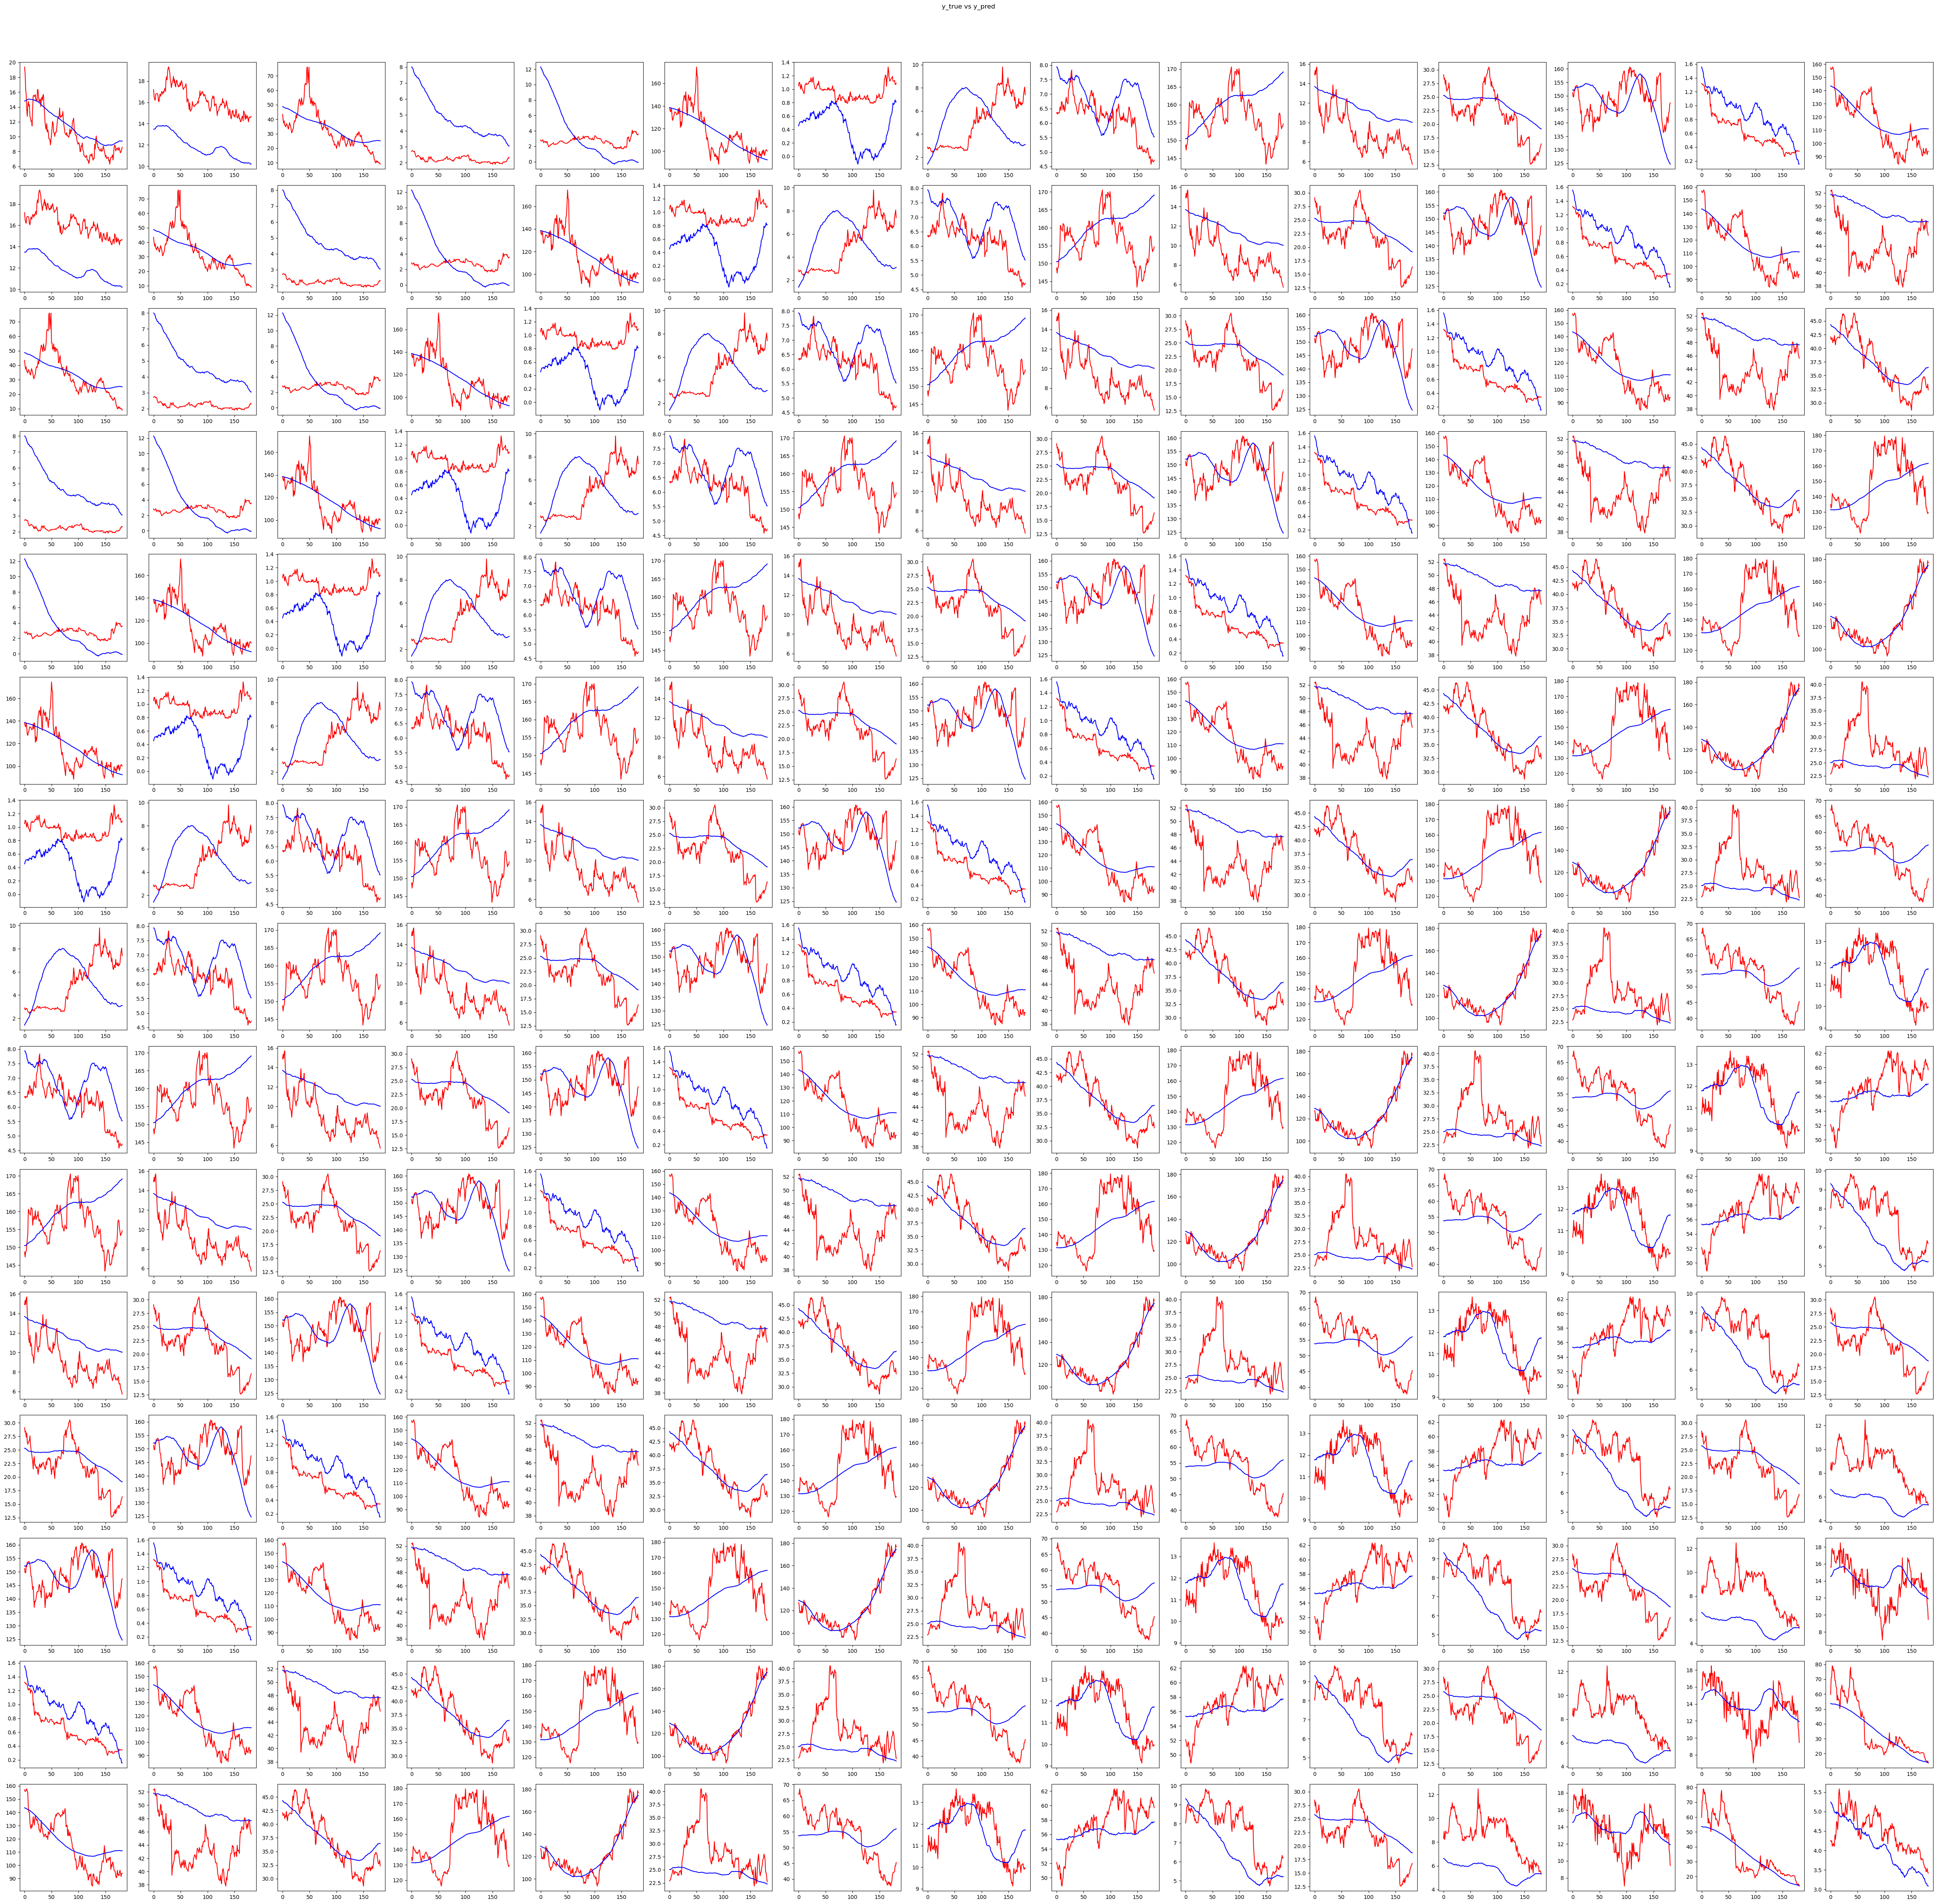

In [22]:
y_test = y_test[:30].cpu()
output = output[:30].cpu()

y_len = y_test.shape[0]

fig, axs = plt.subplots(int(y_len/2),y_len-int(y_len/2),figsize=(50, 50))
X_axis = np.arange(0, len(y_test[0]), 1)
for i in range(int(y_len/2)):
    for j in range(y_len-int(y_len/2)):
        axs[i][j].plot(X_axis,y_test[i+j], color = 'red', label = 'y_test')
        axs[i][j].plot(X_axis,output[i+j], color = 'blue', label = 'y_pred')
fig.suptitle('y_true vs y_pred')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()